## Block 6 chapter 3

In [1]:
"""Bayesian way"""
import arviz as az
import stan
import nest_asyncio
nest_asyncio.apply()

"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
# plt.rcParams['axes.grid'] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

## Stanコードを書いてみる

ローカルレベルモデルの実装

$\mu_t = \mu_{t-1} + w_t, \quad w_t \sim N(0, \sigma_w^2)$ ・・・状態方程式<br>
$w_t$: 過程誤差<br>
(もしくは，$\mu_t \sim N(\mu_{t-1}, \sigma_w^2)$でも状態方程式を表せる)

$y_t = \mu_t + v_t, \quad v_t \sim N(0, \sigma_v^2)$ ・・・観測方程式<br>
$v_t$: 観測誤差<br>
(もしくは，$y_t \sim N(\mu_t, \sigma_v^2)$でも状態方程式を表せる)

ただし，$\mu_1 \sim N(\mu_0, \sigma_w^2)$．$\mu_0$は状態の初期値．

In [2]:
# data
n_sample = 100 # number of samples
y = np.zeros(n_sample)

# parameters
mu_zero = 100 # initial value of state
mu = np.zeros(n_sample)
s_w = 1000 # variance of process error (sigma_w)
s_v = 5000 # variance of observation error (sigma_v)

y.sum(), mu.sum()

(0.0, 0.0)

## Make model

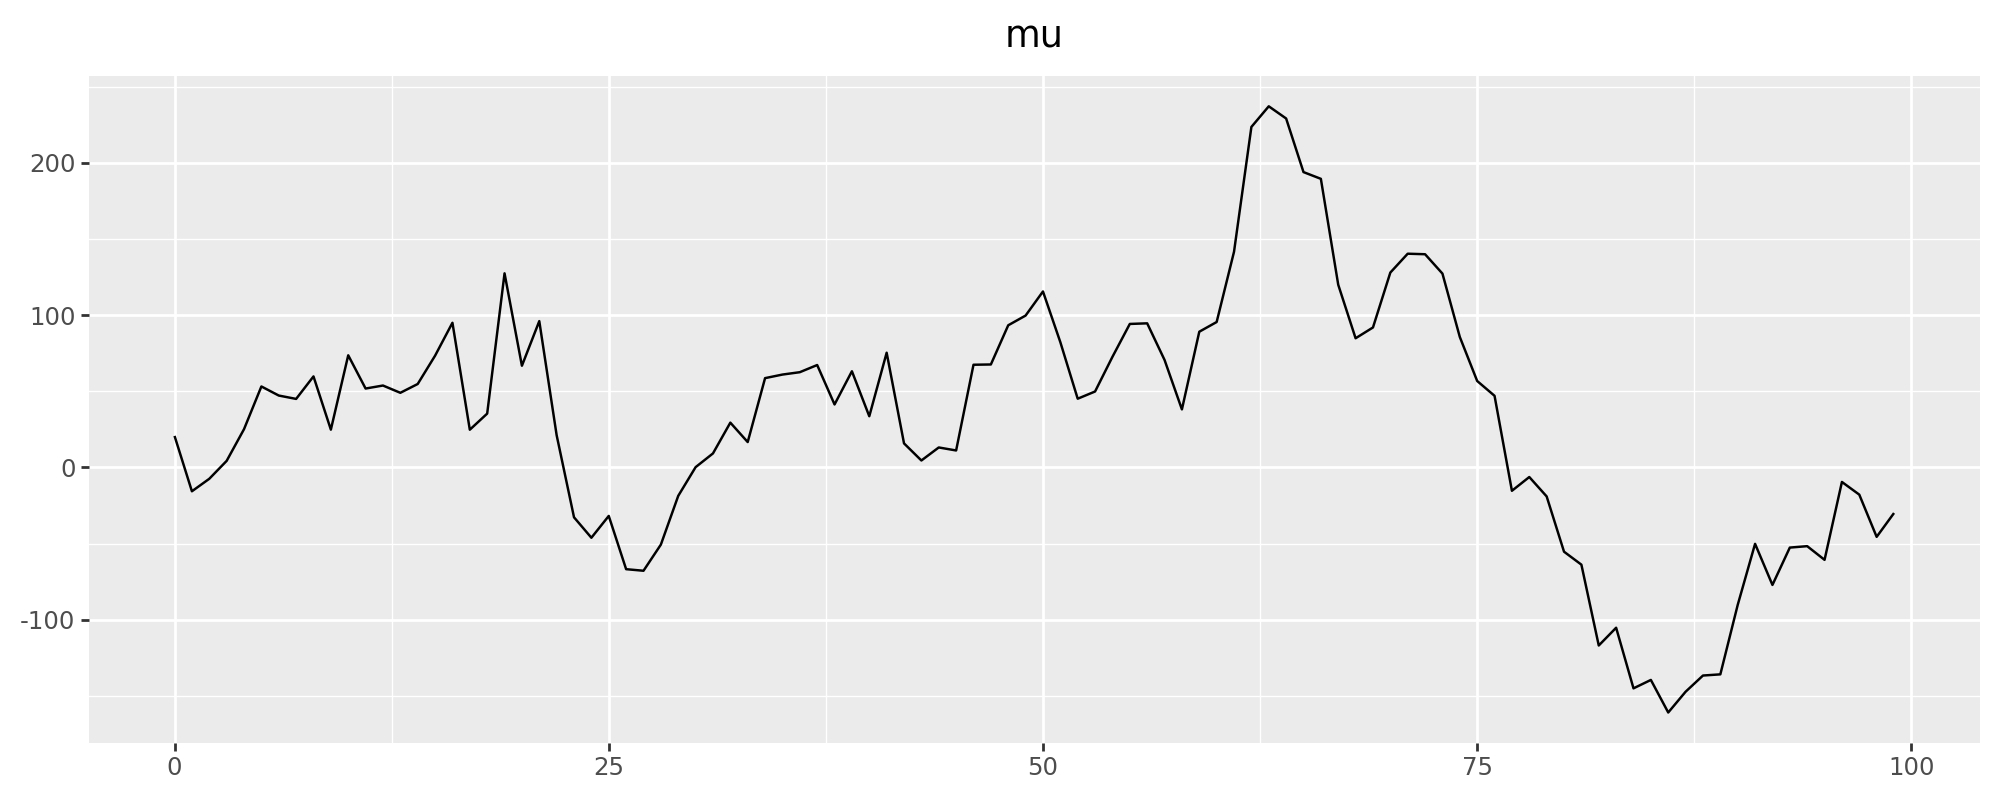

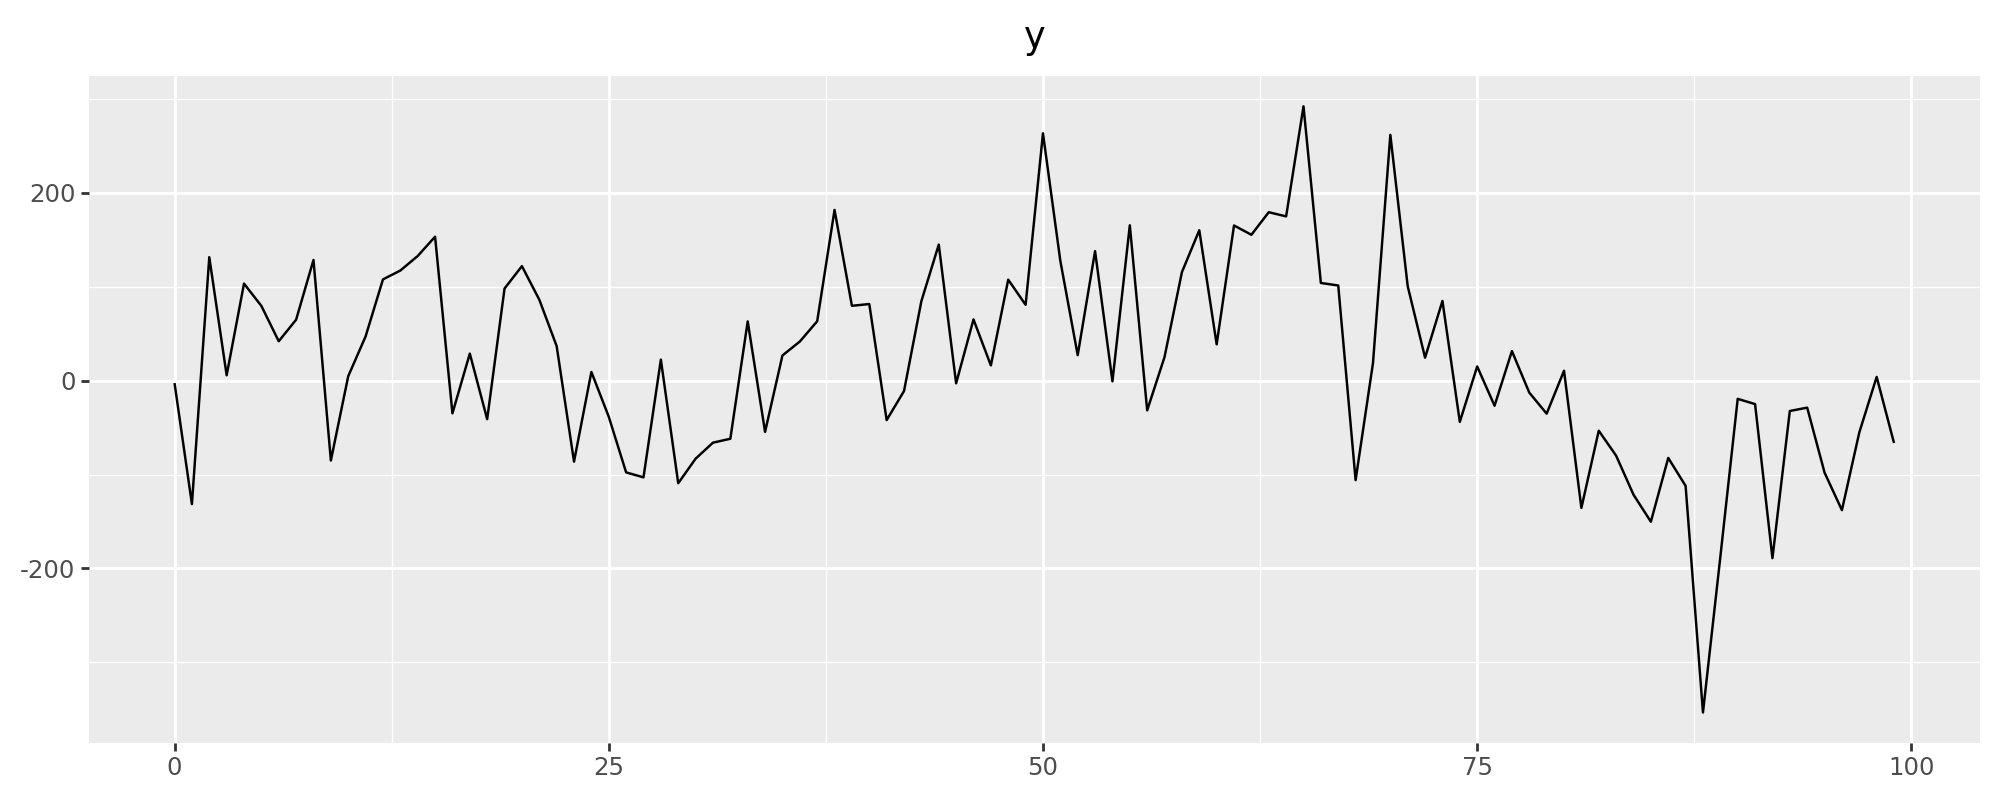

In [3]:
mu[0] = np.random.normal(loc=mu[0], scale=np.sqrt(s_w), size=1)

# equation of observation
for i in range(1, n_sample):
    mu[i] = np.random.normal(loc=mu[i-1], scale=np.sqrt(s_w), size=1)

# equation of state
for i in range(0, n_sample):
    y[i] = np.random.normal(loc=mu[i], scale=np.sqrt(s_v), size=1)
    
gg1 = (
    ggplot()
    + geom_line(aes(x=range(len(mu)), y=mu))
    # + theme(figure_size=(10, 4), axis_text_x=element_blank())
    + theme(figure_size=(10, 4))
    + labs(title="mu")
)
gg2 = (
    ggplot()
    + geom_line(aes(x=range(len(y)), y=y))
    + theme(figure_size=(10, 4))
    + labs(title="y")
)
print(gg1, end="")
print(gg2, end="")

Rとpystanのsample()の出力の形式が違うみたい

e.g.) iter (num_samples) = 5000, warmup (num_warmup) = 2500, thin (num_thin) = 5, chains (num_chains) = 4 の時

R stan だと
- Number of Draws = ((iter - warmup) / thin) * chains = 2000
- iterにwarmupが含まれてるから，実質サンプリングに使われてるのが iter - warmup で，そこからthinが適用される
- つまり，2000行の出力が返ってくる

Pystan だと
- Number of Draws = (num_samples / num_thin) * num_chains = 4000
- num_samplesにwarmupが含まれていない，5000回のサンプリングの前にwarmupをしてる．
- つまり4000行の出力が返ってくる
- R stan に合わせようとすると
  - num_samples = num_samples - num_warmup = 2500, num_warmup, num_thin, num_chainsを同じにするとなる

In [4]:
df = {"n_sample": n_sample, "y": y}
with open("6-3.stan", "r") as fstan:
    posterior = stan.build(fstan.read(), data=df, random_seed=1023)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=2500, num_thin=5)
result = fit.to_frame()
result = result.drop(['accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'], axis=1)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   0% (3/20000)
Sampling:   0% (4/20000)
Sampling:   1% (103/20000)
Sampling:   2% (302/20000)
Sampling:   3% (601/20000)
Sampling:   5% (1000/20000)
Sampling:  10% (2000/20000)
Sampling:  16% (3100/20000)
Sampling:  21% (4200/20000)
Sampling:  28% (5500/20000)
Sampling:  34% (6800/20000)
Sampling:  52% (10500/20000)
Sampling:  70% (14100/20000)
Sampling:  87% (17400/20000)
Sampling: 100% (20000/20000)
Sampling: 100% (20000/20000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 1

In [5]:
result

parameters,lp__,mu_zero,mu.1,mu.2,mu.3,mu.4,mu.5,mu.6,mu.7,mu.8,...,mu.93,mu.94,mu.95,mu.96,mu.97,mu.98,mu.99,mu.100,s_w,s_v
draws,,,,,,,,,,,,,,,,,,,,,
0,-871.265067,-132.251885,-43.342898,-31.614056,7.929492,92.278952,67.839280,133.286951,46.491199,40.075280,...,-128.362127,-149.530778,-94.249148,-77.996047,-13.084119,-10.483934,-38.716996,-75.043517,1083.847977,5974.508862
1,-800.551213,92.345028,84.719227,79.539148,72.974992,90.364224,89.093694,110.272699,98.731513,97.523048,...,-67.269412,-62.393051,-56.170599,-32.380017,-46.338051,-57.934437,-72.041536,-78.024018,257.984558,9268.350459
2,-882.518405,65.995736,4.930595,-3.417889,93.644906,101.495792,179.513727,139.439619,154.628888,122.015624,...,-21.965138,-3.942319,-23.258719,-108.004077,-129.382010,-41.164945,-84.129709,-85.757627,1467.481189,5450.064575
3,-840.379725,11.355706,37.990053,-5.755912,13.687911,8.516816,40.964610,62.330493,45.682388,62.971164,...,-121.303993,-97.149113,-82.752204,-84.170695,-61.742229,-39.965221,-20.825096,-38.807796,604.402529,4730.994982
4,-844.579455,46.979834,32.147838,9.001261,32.241966,65.002902,46.190541,112.015384,79.302826,54.660784,...,-56.245092,-94.946484,-99.940238,-73.077339,-97.666271,-85.806653,-73.767695,-117.912769,989.157062,4994.501102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-807.984568,20.553443,26.236853,27.172098,50.342964,54.530973,76.555879,76.700919,90.252528,102.984816,...,-54.553074,-57.644020,-60.937871,-61.374121,-58.581623,-47.925968,-33.169071,-12.248466,379.871292,5164.190890
1996,-854.902010,-56.411958,-37.469248,-36.776585,-34.402224,5.274530,43.325170,85.664889,83.366151,95.241424,...,-90.130532,-78.206928,-84.615728,-94.622982,-68.957248,-49.720376,6.222738,-3.298193,504.365411,4362.851208
1997,-842.154151,-49.498358,-47.540343,-17.018656,-2.968037,30.083331,40.692997,68.854288,74.088334,60.663736,...,-83.332984,-92.985479,-104.332351,-60.073237,-85.446046,-48.473140,-57.794229,-110.570396,866.829880,5458.263656


In [6]:
mu_name = [f"mu.{i}" for i in range(1, n_sample+1)]
result_mu = result[mu_name].values
result_mu[:, 0] # 1時点のサンプリングデータ
result_mu[0, :] # 1 ~ 100時点の状態

array([ -43.34289836,  -31.61405572,    7.92949164,   92.27895202,
         67.83927964,  133.28695102,   46.49119949,   40.07527953,
         81.6011561 ,   44.8736402 ,  -10.20084393,   40.29495401,
         14.19552708,   54.54306899,   82.84636718,   49.09481719,
         18.31274133,   -5.50510731,   28.23777616,   42.17319696,
         36.9378293 ,   -7.30052385,   -8.40816662,  -14.0384531 ,
         20.02667722,   -4.46718345,  -37.34009907,  -27.98770452,
        -42.52955884,   -8.30107212,   -6.31180231,  -38.11429078,
        -18.07278541,   26.6478523 ,   36.75168568,   24.2125028 ,
         15.72050778,   57.9303223 ,   36.91268312,   83.85961605,
         64.76999503,   75.56397126,   39.82460151,   48.63436801,
          7.07708282,    2.64646939,   59.46132091,   56.73312111,
         57.41308852,   95.72468265,   76.31362237,   88.53438103,
         89.69154415,  132.25385053,  116.9048358 ,   62.96334483,
         59.1875622 ,   64.06983465,  121.04882056,  126.72276

In [7]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_zero,3.820,54.927,-94.411,106.965,1.231,0.877,1992.0,1775.0,1.00
mu[0],5.398,43.792,-75.964,87.799,0.990,0.700,1963.0,1851.0,1.00
mu[1],6.723,39.119,-63.382,82.387,0.933,0.660,1760.0,1837.0,1.00
mu[2],32.291,35.092,-31.187,97.500,0.757,0.546,2150.0,1931.0,1.00
mu[3],37.537,34.551,-29.174,101.496,0.757,0.554,2080.0,1955.0,1.00
...,...,...,...,...,...,...,...,...,...
mu[97],-67.476,35.774,-135.400,-3.207,0.808,0.575,1964.0,1569.0,1.00
mu[98],-57.241,38.092,-126.178,15.419,0.846,0.610,2017.0,1673.0,1.00
mu[99],-58.675,41.947,-139.724,17.833,0.937,0.662,2004.0,1973.0,1.00
s_w,998.005,549.653,232.838,1971.340,23.174,16.395,486.0,940.0,1.01


In [8]:
result[mu_name]

parameters,mu.1,mu.2,mu.3,mu.4,mu.5,mu.6,mu.7,mu.8,mu.9,mu.10,...,mu.91,mu.92,mu.93,mu.94,mu.95,mu.96,mu.97,mu.98,mu.99,mu.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-43.342898,-31.614056,7.929492,92.278952,67.839280,133.286951,46.491199,40.075280,81.601156,44.873640,...,-142.197766,-94.433314,-128.362127,-149.530778,-94.249148,-77.996047,-13.084119,-10.483934,-38.716996,-75.043517
1,84.719227,79.539148,72.974992,90.364224,89.093694,110.272699,98.731513,97.523048,88.163411,88.089351,...,-79.518179,-60.694834,-67.269412,-62.393051,-56.170599,-32.380017,-46.338051,-57.934437,-72.041536,-78.024018
2,4.930595,-3.417889,93.644906,101.495792,179.513727,139.439619,154.628888,122.015624,132.023521,41.198231,...,-87.856429,-39.444754,-21.965138,-3.942319,-23.258719,-108.004077,-129.382010,-41.164945,-84.129709,-85.757627
3,37.990053,-5.755912,13.687911,8.516816,40.964610,62.330493,45.682388,62.971164,75.626852,48.144288,...,-47.715978,-96.865169,-121.303993,-97.149113,-82.752204,-84.170695,-61.742229,-39.965221,-20.825096,-38.807796
4,32.147838,9.001261,32.241966,65.002902,46.190541,112.015384,79.302826,54.660784,30.532258,45.385489,...,-110.405818,-82.746918,-56.245092,-94.946484,-99.940238,-73.077339,-97.666271,-85.806653,-73.767695,-117.912769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,26.236853,27.172098,50.342964,54.530973,76.555879,76.700919,90.252528,102.984816,87.511093,76.046428,...,-89.663502,-55.622613,-54.553074,-57.644020,-60.937871,-61.374121,-58.581623,-47.925968,-33.169071,-12.248466
1996,-37.469248,-36.776585,-34.402224,5.274530,43.325170,85.664889,83.366151,95.241424,82.610666,36.421985,...,-95.195180,-88.507185,-90.130532,-78.206928,-84.615728,-94.622982,-68.957248,-49.720376,6.222738,-3.298193
1997,-47.540343,-17.018656,-2.968037,30.083331,40.692997,68.854288,74.088334,60.663736,17.037646,-3.430577,...,-56.365607,-89.163466,-83.332984,-92.985479,-104.332351,-60.073237,-85.446046,-48.473140,-57.794229,-110.570396


mu.1, mu.2, ... mu.99, mu.100 はそれぞれ，t時点のサンプリングされた状態たち．<br>
つまり，ある分布に従う乱数．上記で述べたサンプリングの数だけある (2000コ).

In [9]:
percentile = result[mu_name].apply(np.percentile, axis=0, args=([2.5, 50, 97.5],))
percentile = percentile.T
percentile.columns = ["lwr", "fit", "upr"]
percentile

,lwr,fit,upr
parameters,,,
mu.1,-84.448440,6.226628,88.142226
mu.2,-71.535011,6.792823,82.080703
mu.3,-34.923145,33.243152,101.419834
mu.4,-30.637659,36.906031,107.142258
mu.5,-13.814792,49.911360,118.607431
...,...,...,...
mu.96,-144.531294,-80.992606,-13.212359
mu.97,-145.536730,-78.975110,-7.730834
mu.98,-134.901698,-67.871311,4.847696


それぞれ，2.5%, 50%, 97.5%分位数，つまり95%信頼区間を表している．

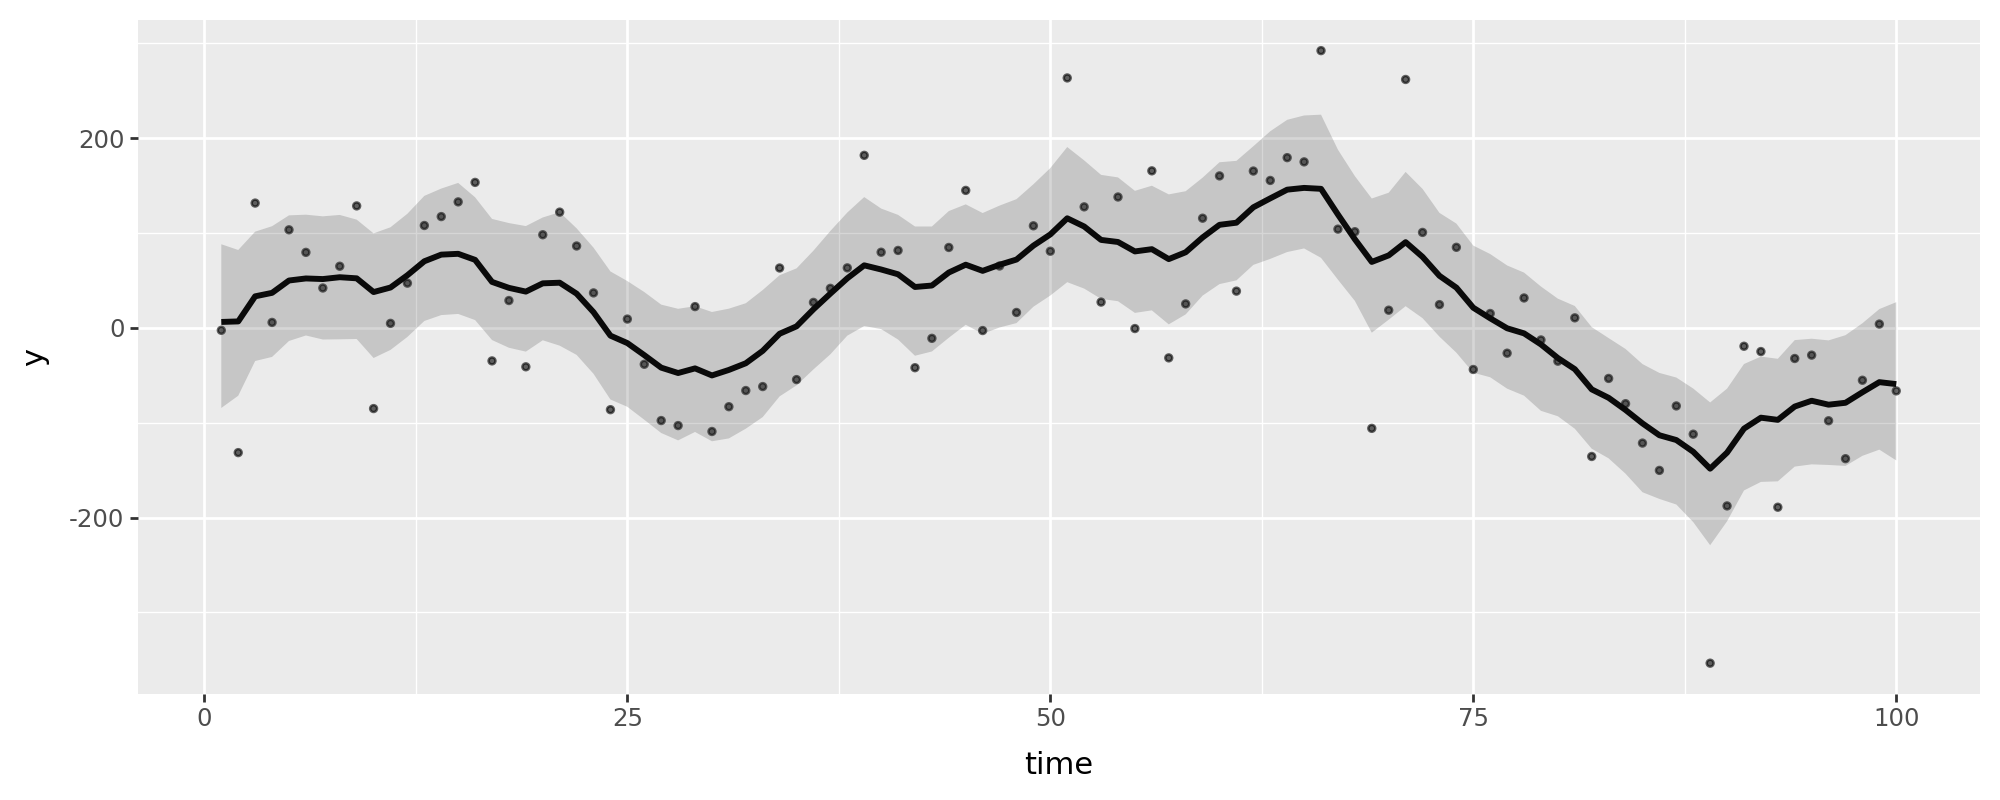

In [14]:
percentile["y"] = y
percentile["time"] = range(1, len(percentile)+1)
(
    ggplot(percentile, aes(x="time"))
    + geom_point(aes(y="y"), alpha=0.6, size=0.9)
    + geom_line(aes(y="fit"), size=1.2)
    + geom_ribbon(aes(ymin="lwr", ymax="upr"), alpha=0.2)
    + theme(figure_size=(10, 4))
)

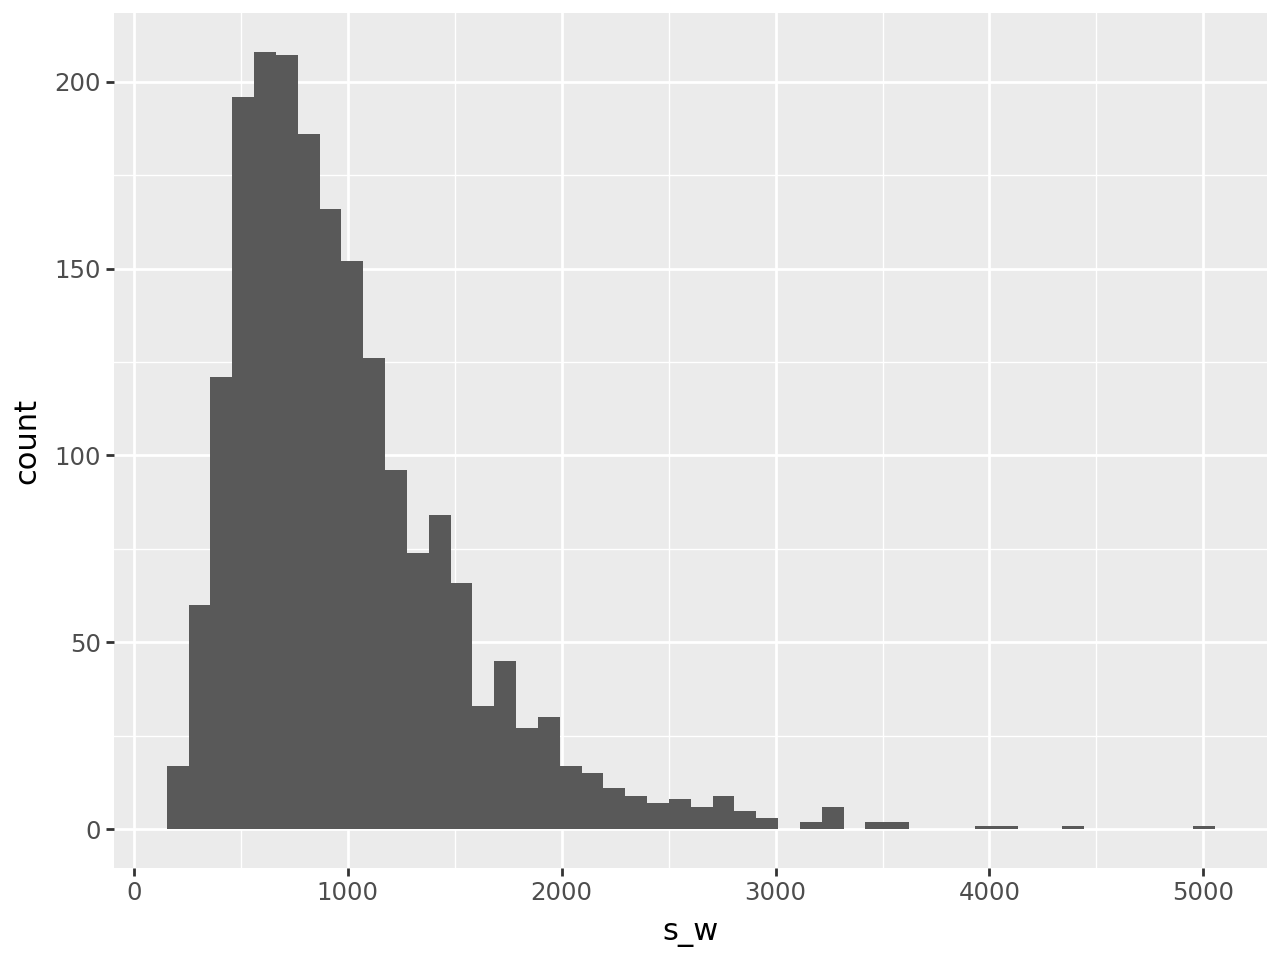

In [11]:
(
    ggplot()
    + geom_histogram(aes(x=result["s_w"]))
)

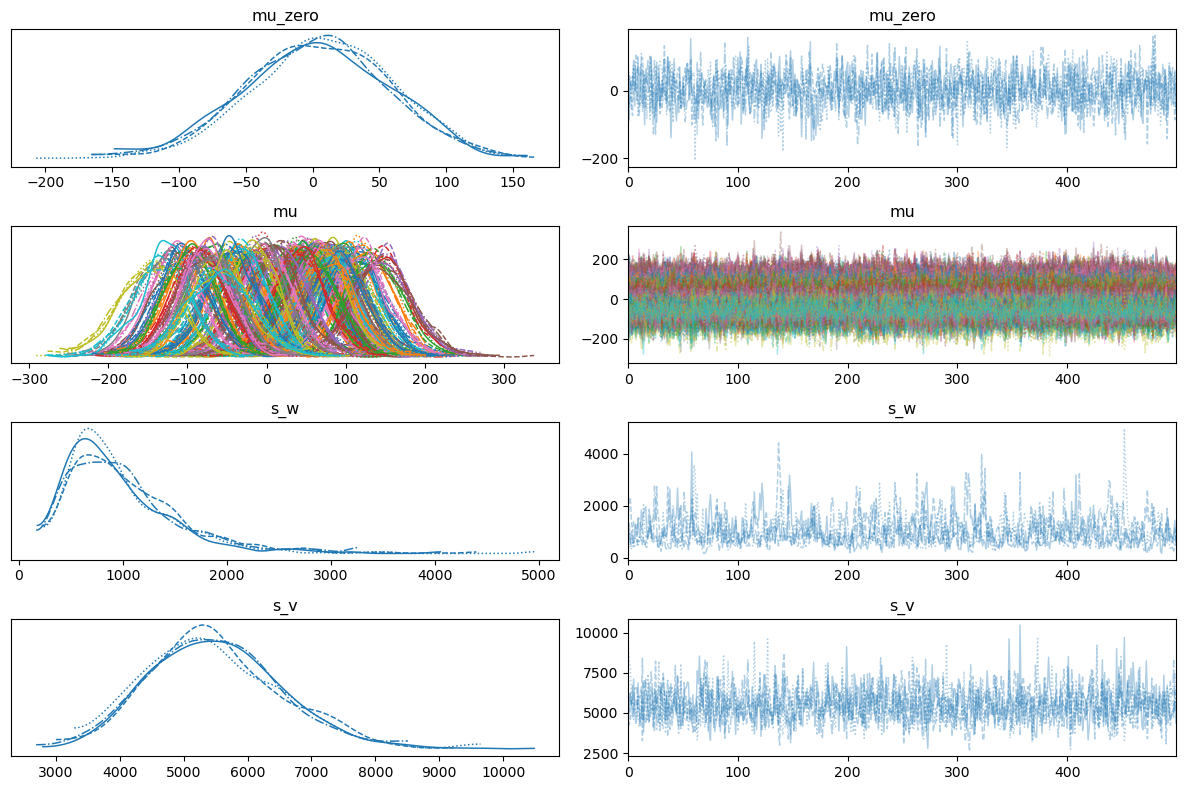

In [12]:
az.plot_trace(fit)
plt.tight_layout()